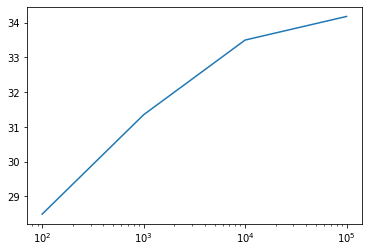

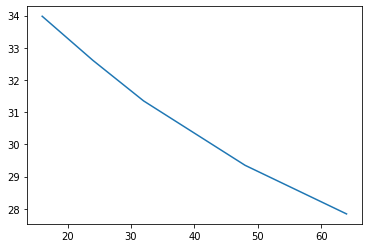

In [12]:
n = [100,1000,10000,100000]
PSNR = [28.49,31.35,33.50,34.18]
plt.semilogx(n, PSNR)
plt.show()
########## no need #########
f_num = [16,24,32,48,64]
PSNR = [33.98,32.61,31.35,29.35,27.84]
plt.plot(f_num, PSNR)
plt.show()

In [3]:
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import cv2

from models import SRCNN
from utils import calc_psnr
from datasets import Camera
import glob

In [32]:
cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = SRCNN().to(device)

n_photon=1000
f_num=16

state_dict = model.state_dict()
path = glob.glob('outputs/{}x{}/*.pth'.format(n_photon, f_num))
for n, p in torch.load(path[0], map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)

model.eval()

image = cv2.imread('/media/qian/7f6908d4-b97f-4a1e-ba90-d502c5308801/DIV2K_valid_HR/0831.png', 0)
image = np.array(image).astype(np.float32)/255.
y = Camera(n_photon=n_photon,f_num=f_num).forward(image)
y_t = torch.from_numpy(y).float().to(device)
y_t = y_t.unsqueeze(0).unsqueeze(0)

image_t = torch.from_numpy(image).float().to(device).unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    preds = model(y_t).clamp(0.0, 1.0)

preds = preds[0, 0].cpu().numpy()

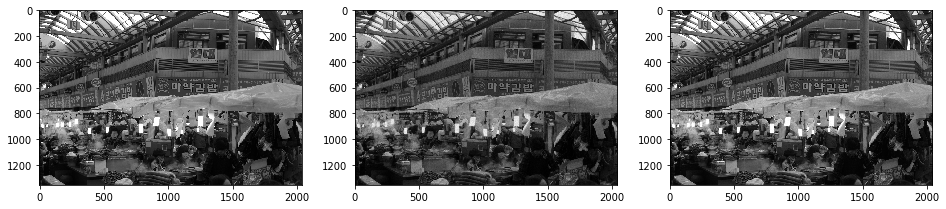

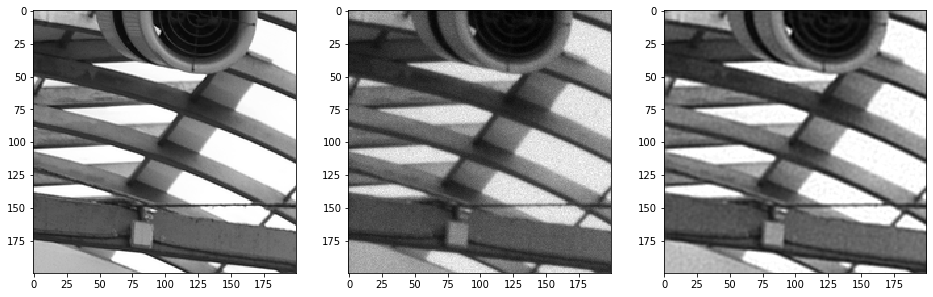

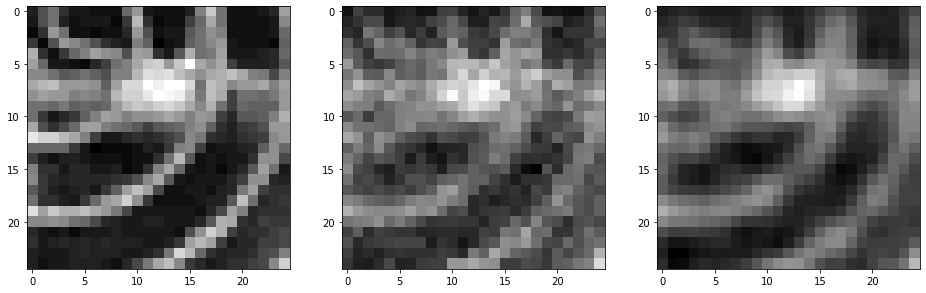

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(16, 10))
ax[0].imshow(image,cmap='gray')
ax[1].imshow(y,cmap='gray')
ax[2].imshow(preds,cmap='gray')
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(16, 10))
ax[0].imshow(image[:200, :200],cmap='gray')
ax[1].imshow(y[:200, :200],cmap='gray')
ax[2].imshow(preds[:200, :200],cmap='gray')
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(16, 10))
ax[0].imshow(image[:25, 125:150],cmap='gray')
ax[1].imshow(y[:25, 125:150],cmap='gray')
ax[2].imshow(preds[:25, 125:150],cmap='gray')
plt.show()